# 1. Prepare

## 1.1. Settings

In [1]:
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import time

%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
input_size = 299
dropout = 0.8
batch_size = 16
batch_size_val = 16

epochs_phase_1 = 10
epochs_phase_2 = 20
epochs_phase_3 = 20

cpu_threads = 8

output_directory = './output/inceptionV3_20171108_new_dataset'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    os.makedirs(os.path.join(output_directory, 'checkpoints'))

## 1.2. Data and augmentaion

In [3]:
train_directory = './dataset_20171026_jpg_no_side/train'
validation_directory = './dataset_20171026_jpg_no_side/validation'
test_directory = './dataset_20171026_jpg_no_side/test'

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=.1,
    height_shift_range=.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='reflect')

validgen = ImageDataGenerator(rescale=1./255)

testgen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_directory,
    target_size=(input_size, input_size),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

validation_generator = validgen.flow_from_directory(
    validation_directory,
    target_size=(input_size, input_size),
    class_mode='categorical',
    batch_size=batch_size_val,
    shuffle=True)

test_generator = testgen.flow_from_directory(
    test_directory,
    target_size=(input_size, input_size),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

train_samples = train_generator.samples
validation_samples = validation_generator.samples
test_samples = test_generator.samples

num_classes = train_generator.num_class

Found 4467 images belonging to 5 classes.
Found 4960 images belonging to 5 classes.
Found 493 images belonging to 5 classes.


## 1.3. Model

In [5]:
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(input_size, input_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(dropout)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 2. Train

## 2.1. Phase 1
Train only the top layers (which were randomly initialized).

In [6]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-3),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='{}/checkpoints/phase_1.h5'.format(output_directory),
    save_weights_only=True,
    save_best_only=True)

csv_logger = CSVLogger('{}/logs/phase_1.csv'.format(output_directory), separator=';')

early_stopper = EarlyStopping(
    monitor='val_acc',
    min_delta=0.05,
    patience=2,
    verbose=1)

tensorboard = TensorBoard(
    log_dir='{}/logs/phase_1'.format(output_directory),
    write_graph=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs_phase_1,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size_val,
    verbose=1,
    callbacks=[csv_logger, checkpointer, early_stopper, tensorboard],
    workers=cpu_threads)

Epoch 1/10
279/279 [==============================] - 112s - loss: 2.5942 - acc: 0.2843 - val_loss: 1.4118 - val_acc: 0.3917
Epoch 2/10
279/279 [==============================] - 107s - loss: 1.4645 - acc: 0.3675 - val_loss: 1.4670 - val_acc: 0.3508
Epoch 3/10
279/279 [==============================] - 103s - loss: 1.4155 - acc: 0.3938 - val_loss: 1.2540 - val_acc: 0.4788
Epoch 4/10
279/279 [==============================] - 108s - loss: 1.3590 - acc: 0.4073 - val_loss: 1.2062 - val_acc: 0.5218
Epoch 5/10
279/279 [==============================] - 110s - loss: 1.3379 - acc: 0.4318 - val_loss: 1.1715 - val_acc: 0.5236
Epoch 6/10
279/279 [==============================] - 108s - loss: 1.3512 - acc: 0.4286 - val_loss: 1.1325 - val_acc: 0.5601
Epoch 7/10
279/279 [==============================] - 110s - loss: 1.3469 - acc: 0.4299 - val_loss: 1.1405 - val_acc: 0.5597
Epoch 8/10
279/279 [==============================] - 103s - loss: 1.3272 - acc: 0.4459 - val_loss: 1.0738 - val_acc: 0.5714


Load best epoch:

In [7]:
model.load_weights('{}/checkpoints/phase_1.h5'.format(output_directory))

## 2.2. Phase 2
At this point, the top layers are well trained and we can start fine-tuning convolutional layers from inception V3. We will freeze the bottom N layers and train the remaining top layers.

In [8]:
# train the top 2 inception blocks
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.adam(lr=1e-4),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='{}/checkpoints/phase_2.h5'.format(output_directory),
    save_weights_only=True,
    save_best_only=True)

csv_logger = CSVLogger('{}/logs/phase_2.csv'.format(output_directory), separator=';')

early_stopper = EarlyStopping(
    monitor='val_acc',
    min_delta=0.01,
    patience=5,
    verbose=1)

tensorboard = TensorBoard(
    log_dir='{}/logs/phase_2'.format(output_directory),
    write_graph=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs_phase_2,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size_val,
    verbose=1,
    callbacks=[checkpointer, csv_logger, early_stopper, tensorboard],
    workers=cpu_threads)

Epoch 1/20
279/279 [==============================] - 117s - loss: 1.0949 - acc: 0.5491 - val_loss: 0.9643 - val_acc: 0.6137
Epoch 2/20
279/279 [==============================] - 117s - loss: 0.8814 - acc: 0.6518 - val_loss: 0.6498 - val_acc: 0.7296
Epoch 3/20
279/279 [==============================] - 114s - loss: 0.7852 - acc: 0.6972 - val_loss: 0.6037 - val_acc: 0.7696
Epoch 4/20
279/279 [==============================] - 116s - loss: 0.7004 - acc: 0.7323 - val_loss: 0.6194 - val_acc: 0.7694
Epoch 5/20
279/279 [==============================] - 119s - loss: 0.6819 - acc: 0.7490 - val_loss: 0.5878 - val_acc: 0.7776
Epoch 6/20
279/279 [==============================] - 115s - loss: 0.6068 - acc: 0.7789 - val_loss: 0.5239 - val_acc: 0.7964
Epoch 7/20
279/279 [==============================] - 117s - loss: 0.5902 - acc: 0.7881 - val_loss: 0.5317 - val_acc: 0.8016
Epoch 8/20
279/279 [==============================] - 114s - loss: 0.5375 - acc: 0.8081 - val_loss: 0.5993 - val_acc: 0.7774


Load best epoch:

In [9]:
model.load_weights('{}/checkpoints/phase_2.h5'.format(output_directory))

## 2.3. Phase 3
Train all layers.

In [10]:
for layer in model.layers:
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(lr=1e-5, momentum=0.9, nesterov=True),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='{}/checkpoints/phase_3.h5'.format(output_directory),
    save_weights_only=True,
    save_best_only=True)

csv_logger = CSVLogger('{}/logs/phase_3.csv'.format(output_directory), separator=';')

early_stopper = EarlyStopping(
    monitor='val_acc',
    min_delta=0.005,
    patience=5,
    verbose=1)

lr_reduce = ReduceLROnPlateau(verbose=1)

tensorboard = TensorBoard(
    log_dir='{}/logs/phase_3'.format(output_directory),
    write_graph=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs_phase_3,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size_val,
    verbose=1,
    callbacks=[checkpointer, csv_logger, lr_reduce, early_stopper, tensorboard],
    workers=cpu_threads)

Epoch 1/20
279/279 [==============================] - 201s - loss: 0.3358 - acc: 0.8872 - val_loss: 0.3887 - val_acc: 0.8595
Epoch 2/20
279/279 [==============================] - 191s - loss: 0.3257 - acc: 0.8889 - val_loss: 0.3589 - val_acc: 0.8698
Epoch 3/20
279/279 [==============================] - 190s - loss: 0.3080 - acc: 0.8965 - val_loss: 0.3623 - val_acc: 0.8615
Epoch 4/20
279/279 [==============================] - 191s - loss: 0.2860 - acc: 0.9064 - val_loss: 0.3498 - val_acc: 0.8720
Epoch 5/20
279/279 [==============================] - 192s - loss: 0.2922 - acc: 0.9023 - val_loss: 0.3353 - val_acc: 0.8730
Epoch 6/20
279/279 [==============================] - 191s - loss: 0.2831 - acc: 0.9017 - val_loss: 0.3513 - val_acc: 0.8685
Epoch 7/20
279/279 [==============================] - 191s - loss: 0.2888 - acc: 0.9014 - val_loss: 0.3360 - val_acc: 0.8738
Epoch 8/20
279/279 [==============================] - 191s - loss: 0.2594 - acc: 0.9112 - val_loss: 0.3406 - val_acc: 0.8790


Load best epoch:

In [11]:
model.load_weights('{}/checkpoints/phase_3.h5'.format(output_directory))

# 3. Evaluate

## 3.1. Evaluate

In [12]:
score = model.evaluate_generator(test_generator, test_samples)

print('Test accuracy: {:.2f}'.format(score[1]))

Test accuracy: 0.89


## 3.2. Propagation time

In [13]:
# initialize generator to fix imeges order
test_generator = testgen.flow_from_directory(
    test_directory,
    target_size=(input_size, input_size),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

t0 = time.time()
prediction = model.predict_generator(test_generator, test_samples)
pred_time = time.time() - t0

print('Propagation time of {} images: {:.3f} ms ({:.3f} ms per image)'.format(test_samples, pred_time * 1000.0, pred_time / test_samples * 1000.0))

Found 493 images belonging to 5 classes.
Propagation time of 493 images: 13307.694 ms (26.993 ms per image)


## 3.3. Confusion matrix

In [23]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

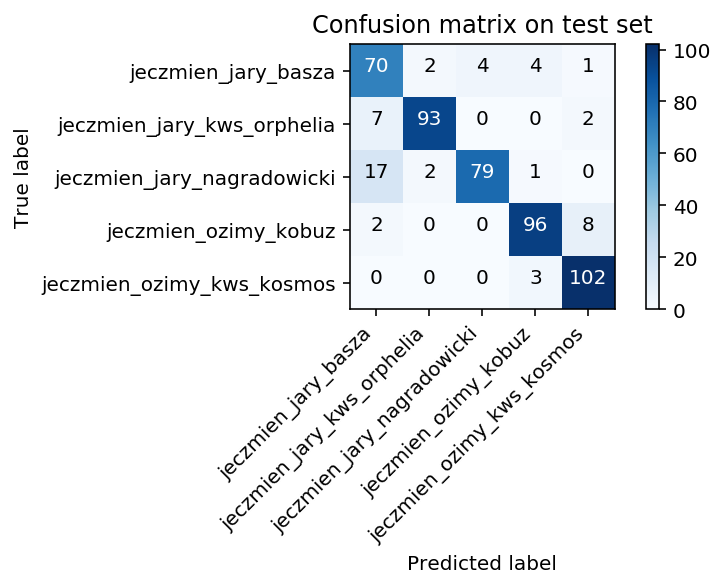

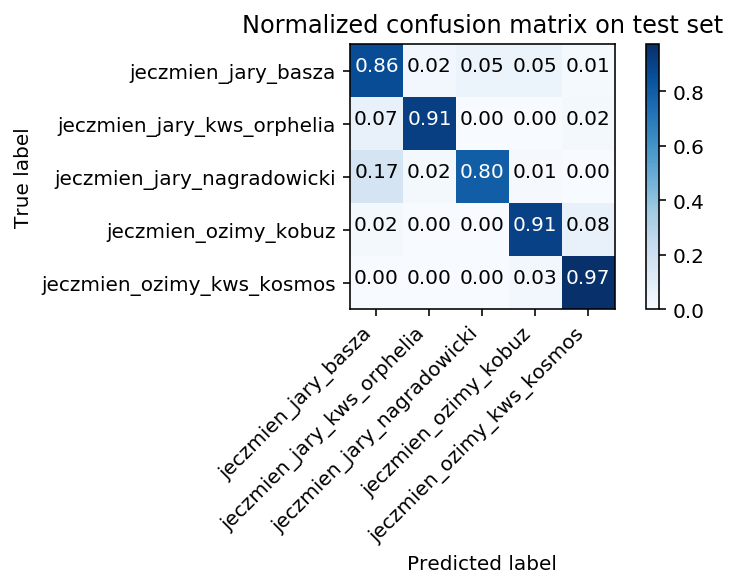

In [24]:
class_names = [key for (key, value) in sorted(test_generator.class_indices.items())]

test_pred = []
for i in prediction:
    test_pred.append(np.argmax(i))

test_cnf_matrix = confusion_matrix(test_generator.classes, test_pred)

np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(test_cnf_matrix, classes=class_names,
                      title='Confusion matrix on test set')
plt.figure()
plot_confusion_matrix(test_cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix on test set')
plt.show()